### 1 清洗动漫评论数据

使用的数据集名称是MyAnimeList - Anime Dataset with Reviews来自kaggle
数据集网址```https://www.kaggle.com/datasets/ansh0007/myanimelist-anime-dataset-with-reviews```
关于数据集的描述

[![pCAQJoD.png](https://s1.ax1x.com/2023/06/08/pCAQJoD.png)](https://imgse.com/i/pCAQJoD)

数据集包含五列信息，即 S.no、标题、评论日期、用户名和文本。S.no 列包含数据集中每条评论的唯一标识符，而标题列包含正在审核的动漫的名称。“评论日期”列指示发布评论的日期，而“用户名”列显示发布评论的人员的用户名。最后，文本列包含用户对相关动漫留下的实际评论或评论。在数据集中拥有大量评论也意味着代表各种各样的意见和观点。这对于想要探索动漫社区内意见多样性或调查不同因素（例如流派或发布日期）如何影响用户意见的研究人员非常有用。
关于表的结构
[![pCAQNJH.png](https://s1.ax1x.com/2023/06/08/pCAQNJH.png)](https://imgse.com/i/pCAQNJH)

In [5]:
import pandas as pd
import re

# 定义一个函数检查文本中是否包含emoji
def contains_emoji(text):
    # 定义一个正则表达式匹配emoji字符
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    # 返回文本是否包含emoji
    return bool(emoji_pattern.search(text))

# 定义一个函数修剪评论文本
def trim_comment(text):
    # 去除多余的空白符
    text = " ".join(text.split())
    # 截断至30个词
    text = " ".join(text.split()[:30])
    return text

# 加载Excel数据文件
df = pd.read_excel('anime_reviews.xlsx')

# 过滤数据，仅保留"Recommended"标签的评论
df = df[df['Tag'] == 'Recommended']

# 删除包含emoji的评论
df = df[~df['text'].apply(contains_emoji)]

# 应用trim_comment函数，截断评论至30个词并去除空行
df['text'] = df['text'].apply(trim_comment)

# 删除重复项，每位用户对每部作品只能评论一次，如果有多次评论，保留第一条评论
df = df.drop_duplicates(subset=['User', 'Title'], keep='first')

# 删除不需要的列，这里删除'Tag'列
df = df.drop(columns=['Tag'])

# 仅保留前24396条记录
df = df.head(24396)

# 修改列名，将'S.no'重命名为'Sno'
df.rename(columns={'S.no': 'Sno'}, inplace=True)

# 重新编排Sno列，使其成为一个连续的序列
df['Sno'] = range(1, len(df) + 1)

# 将清理后的数据保存为CSV文件
df.to_csv('comment3.csv', index=False)


### 2 将清洗后的文件上传至hdfs的根目录，名称为comment3.csv

 #### 2.1 采用scala语言进行spark编程对下面hdfs的/目录下的数据文件commment3.csv按照text属性去除虚词和无意义的词进行词频统计，并在根目录下产生一个wordcount.csv文件储存有用户评论的词频统计的结果，以方便我来后期用python的wordcloud来生成词云图

```
import org.apache.spark.sql.functions._
import org.apache.spark.ml.feature.{Tokenizer, StopWordsRemover}
import org.apache.spark.sql._

// 读取comment.csv
val inputPath = "hdfs://hadoop01:9000/comment3.csv"
val df = spark.read.format("csv")
  .option("header", "true")
  .option("inferSchema", "true")
  .load(inputPath)

// Tokenize文本
val tokenizer = new Tokenizer().setInputCol("text").setOutputCol("words")
val tokenized = tokenizer.transform(df)

// 删除停止词
val remover = new StopWordsRemover().setInputCol("words").setOutputCol("filteredWords")
val filtered = remover.transform(tokenized)

// 计算词频
val wordCounts = filtered.select(explode(col("filteredWords")).as("word"))
  .groupBy("word")
  .count()
  .orderBy(desc("count"))

// 写入wordcount.csv
// 将数据集的分区数减少到1
// 改成输出目录，而不是具体的文件名
val outputPath = "hdfs://hadoop01:9000/wordcount_output" 
wordCounts.coalesce(1) .write.format("csv").option("header", "true").mode("overwrite").save(outputPath)
```


这段Scala代码主要用于Apache Spark的数据处理，具体来说，它读取了一份存在于HDFS（Hadoop Distributed File System）上的comment.csv文件，然后对其中的"text"字段进行了词语划分（tokenization），删除了停用词（stop words），最后计算了每个词的出现次数，并按次数降序排序，最后将结果写入wordcount.csv文件。

#### 2.1.1 将产生的结果文件从hdfs中下载到本地并且重名名为result.csv，产生用户评论的词云图

###### result.csv的部分数据如下所示
```
word,count
anime,1116
one,497
story,404
show,398
like,361
first,338
really,305
series,297
good,261
season,241
watch,211
review,193
best,176
people,172
much,167
love,163
great,159
watching,158
characters,155

```

##### 2.1.2 此段python代码的作用是生成用户评论热词的词云图

C:\Users\20624\AppData\Local\Temp\ipykernel_29736\2534941806.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('result.csv', error_bad_lines=False)
Skipping line 1031: expected 2 fields, saw 12
Skipping line 2445: expected 2 fields, saw 6
Skipping line 2466: expected 2 fields, saw 9
Skipping line 3323: expected 2 fields, saw 11
Skipping line 4107: expected 2 fields, saw 3
Skipping line 4266: expected 2 fields, saw 7
Skipping line 4449: expected 2 fields, saw 3
Skipping line 4572: expected 2 fields, saw 4
Skipping line 4629: expected 2 fields, saw 6
Skipping line 4655: expected 2 fields, saw 5
Skipping line 4744: expected 2 fields, saw 3
Skipping line 4786: expected 2 fields, saw 4
Skipping line 4860: expected 2 fields, saw 5
Skipping line 5347: expected 2 fields, saw 5
Skipping line 5416: expected 2 fields, saw 8
Skipping line 5473: expected 2 fields, saw 9
Skipping line 

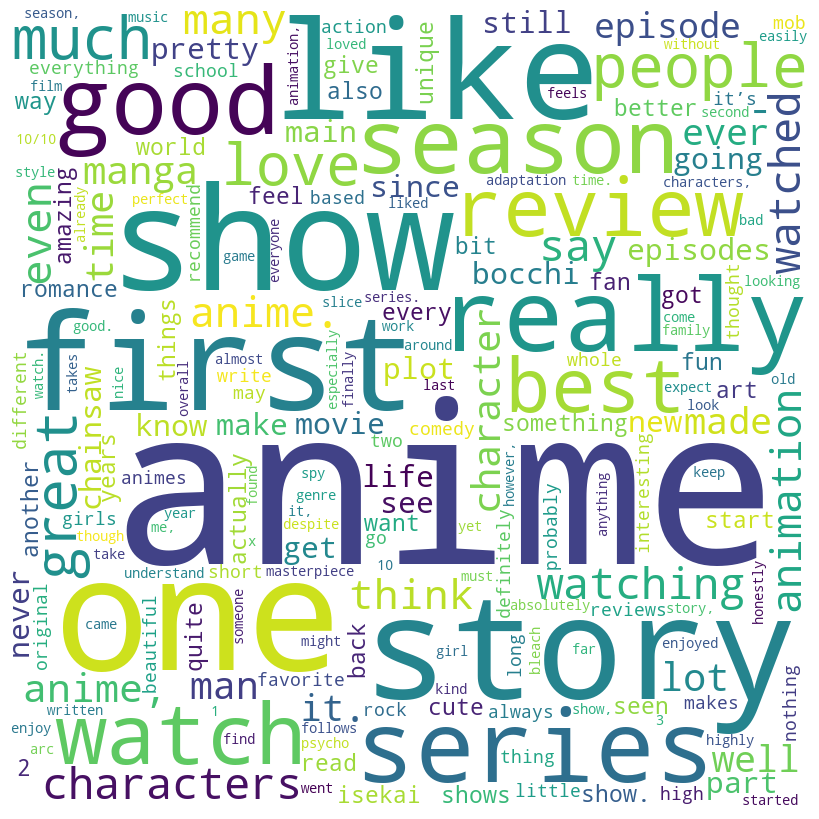

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# 读取CSV文件
data = pd.read_csv('result.csv', error_bad_lines=False)


# 转换数据到字典格式，用于词云的输入
word_freq = dict(zip(data['word'], data['count']))

# 定义要移除的无意义词汇
stopwords = set(["much", "lot", "one", "say"])

# 创建词云对象
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate_from_frequencies(word_freq)

# 绘制词云图
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# 显示图
plt.show()


##### 2.2 对动漫的标题进行词频统计，并将统计的词汇结果生成动漫标题词云图

##### 2.2.1 编写scala代码用以对动漫标题词频进行统计，并将结果保存在集群的hdfs中，代码如下所示：

```
import org.apache.spark.sql.functions._
import org.apache.spark.ml.feature.{Tokenizer, StopWordsRemover}
import org.apache.spark.sql._

// 读取comment.csv
val inputPath = "hdfs://hadoop01:9000/comment3.csv"
val df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(inputPath)

// Tokenize文本
val tokenizer = new Tokenizer().setInputCol("Title").setOutputCol("words")
val tokenized = tokenizer.transform(df)

// 删除停止词
val remover = new StopWordsRemover().setInputCol("words").setOutputCol("filteredWords")
val filtered = remover.transform(tokenized)

// 计算词频
val wordCounts = filtered.select(explode(col("filteredWords")).as("word")).groupBy("word").count().orderBy(desc("count"))

// 写入wordcount.csv
// 将数据集的分区数减少到1
// 改成输出目录，而不是具体的文件名
val outputPath = "hdfs://hadoop01:9000/Animationwordcount_output" 
wordCounts.coalesce(1).write.format("csv").option("header", "true").mode("overwrite").save(outputPath)
```

##### 2.2.2 将hdfs中生成的结果下载至本地命名为titleRank.csv方便生成词云图

titleRank.csv的部分数据如下所示:title表示动漫的名称，count表示评论的数量
```
Title,count
Kengan Ashura Part 2,1
Seihou Bukyou Outlaw Star,3
"Komi-san wa, Comyushou desu. 2nd Season",37
Yuuki Yuuna wa Yuusha de Aru,5
One Piece Movie 01,3
Ai no Gakkou Cuore Monogatari,1
Steins;Gate 0: Kesshou Takei no Valentine - Bittersweet Intermedio,1
Kaginado,9
Shinryaku! Ika Musume Specials,1
Air Movie,2
Vatican Kiseki Chousakan,2
K,1
Momokuri,1
Kidou Senshi Gundam: The Origin - Zenya Akai Suisei,1
Mushoku Tensei: Isekai Ittara Honki Dasu - Eris no Goblin Toubatsu,12
JoJo no Kimyou na Bouken Part 3: Stardust Crusaders 2nd Season,8
A Kite,2
Arknights: Reimei Zensou,10
Nichijou,13
The Sky Crawlers,5
Bakuman.,10
Fullmetal Alchemist,8
Suzumiya Haruhi no Yuuutsu (2009),4
Shinka no Mi: Shiranai Uchi ni Kachigumi Jinsei,17
```

##### 2.2.3 根据titleRank.csv使用python进行可视化处理

使用pandas、WordCloud和matplotlib库创建并显示一个词云图。

##### 2.2.3 使用python根据动漫标题出现的数量进行可视化

使用Matplotlib和Seaborn库绘制一个水平条形图，展示了2021-2023年评论数排名前20的动漫

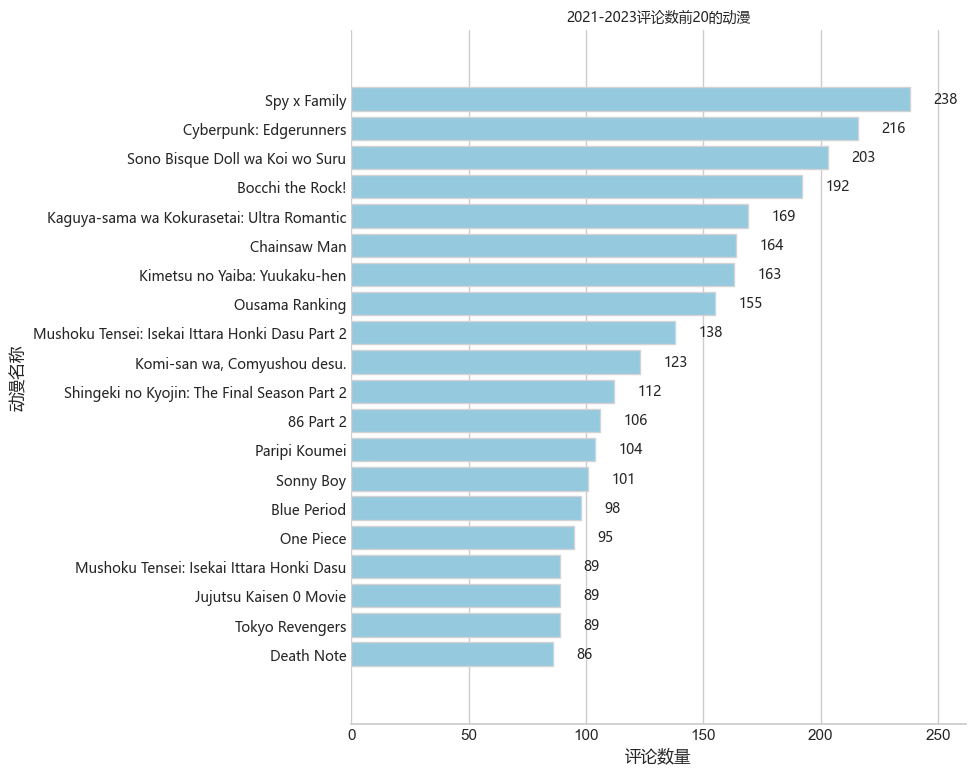

In [19]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

# 设置中文字体
font_path = 'C:\\Windows\\Fonts\\msyh.ttc'  # 或者使用原始字符串：r'C:\Windows\Fonts\msyh.ttc'

# 创建字体属性对象
font_prop = font_manager.FontProperties(fname=font_path)

# 设置字体
plt.rcParams['font.family'] = font_prop.get_name()
sns.set(font=font_prop.get_name())

# 读取CSV文件
data = pd.read_csv('titleRank.csv')

# 按照count列降序排序
sorted_data = data.sort_values(by='count', ascending=False)

# 获取排名前20的动漫
top_20 = sorted_data.head(20)

# 设置Seaborn风格
sns.set_style('whitegrid')
sns.set_palette('pastel')

# 创建水平条形图
plt.figure(figsize=(10, 8))
sns.barplot(x='count', y='Title', data=top_20, color='skyblue', edgecolor='lightgray')

# 添加标题和标签
plt.title('2021-2023评论数前20的动漫', fontsize=16, fontproperties=font_prop)
plt.xlabel('评论数量', fontsize=12, fontproperties=font_prop)
plt.ylabel('动漫名称', fontsize=12, fontproperties=font_prop)

# 调整Y轴标签的位置和间距
plt.yticks(range(len(top_20)), top_20['Title'], fontsize=10, fontproperties=font_prop)
plt.tight_layout()

# 添加数值标签
for i, v in enumerate(top_20['count']):
    plt.text(v + 10, i, str(int(v)), va='center', fontsize=10, fontproperties=font_prop)

# 调整图表边距
plt.margins(0.1)

# 调整边框样式
sns.despine(left=True)

# 调整刻度线样式
plt.tick_params(axis='both', which='both', length=0)

# 展示图表
plt.show()


##### 2.2.4 利用spark编程对comment3.csv进一步处理生成对动漫标题的词频统计的词云图
scala代码如下：
```
import org.apache.spark.sql.functions._
import org.apache.spark.ml.feature.{Tokenizer, StopWordsRemover}
import org.apache.spark.sql._

// 读取comment.csv
val inputPath = "hdfs://hadoop01:9000/comment3.csv"
val df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(inputPath)

// Tokenize文本
val tokenizer = new Tokenizer().setInputCol("Title").setOutputCol("words")
val tokenized = tokenizer.transform(df)

// 删除停止词
val remover = new StopWordsRemover().setInputCol("words").setOutputCol("filteredWords")
val filtered = remover.transform(tokenized)

// 计算词频
val wordCounts = filtered.select(explode(col("filteredWords")).as("word")).groupBy("word").count().orderBy(desc("count"))

// 写入wordcount.csv
// 将数据集的分区数减少到1
// 改成输出目录，而不是具体的文件名
val outputPath = "hdfs://hadoop01:9000/Animationwordcount_output" 
wordCounts.coalesce(1).write.format("csv").option("header", "true").mode("overwrite").save(outputPath)
```

将生成的结果下载到本地并重命名为AnimationWordCount.csv
部分数据如下所示：
```
word,count
wa,1428
ni,973
season,855
wo,779
2,775
part,694
isekai,606
movie,500
ga,457
x,447
sekai,423
2nd,417
de,365
koi,364
suru,327
-,297
kimetsu,287
```

##### 利用wordcloud对生成的结果生成词云图
python代码如下所示：

C:\Users\20624\AppData\Local\Temp\ipykernel_29736\1893628349.py:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('AnimationWordCount.csv', error_bad_lines=False, quoting=3)
Skipping line 56: expected 2 fields, saw 3
Skipping line 197: expected 2 fields, saw 3
Skipping line 215: expected 2 fields, saw 3
Skipping line 252: expected 2 fields, saw 3
Skipping line 291: expected 2 fields, saw 3
Skipping line 321: expected 2 fields, saw 3
Skipping line 356: expected 2 fields, saw 3
Skipping line 375: expected 2 fields, saw 3
Skipping line 408: expected 2 fields, saw 3
Skipping line 446: expected 2 fields, saw 3
Skipping line 710: expected 2 fields, saw 3
Skipping line 827: expected 2 fields, saw 3
Skipping line 900: expected 2 fields, saw 3
Skipping line 1098: expected 2 fields, saw 3
Skipping line 1112: expected 2 fields, saw 3
Skipping line 1218: expected 2 fields, saw 3
Skippin

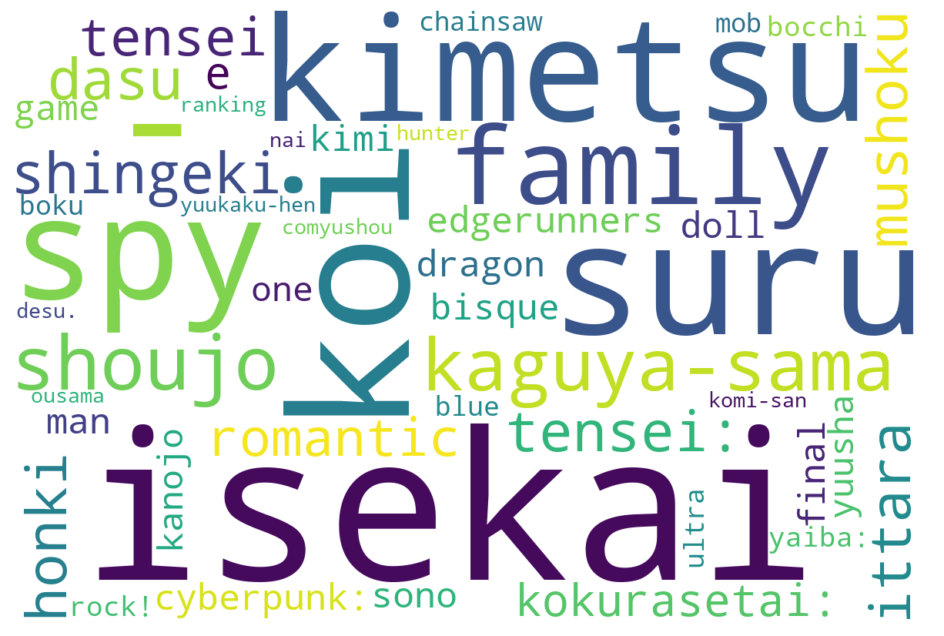

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# 读取数据
try:
    data = pd.read_csv('AnimationWordCount.csv', error_bad_lines=False, quoting=3)
except Exception as e:
    print("读取文件时出错:", e)
    exit()

# 检查'word'列中的值是否为字符串类型，如果是，则去除数字，否则保持不变
data['word'] = data['word'].apply(lambda x: re.sub(r'\d+', '', x) if isinstance(x, str) else x)

# 去除无意义的单词
meaningless_words = ['wa', 'ni', 'wo', 'ga', 'x', 'de', 'na','season','part','movie','nd','sekai']
data = data[~data['word'].isin(meaningless_words)]

# 删除'word'列中为NaN的行
data = data.dropna(subset=['word'])

# 创建词云图，设置较大的宽度和高度，以及最大字体大小和最大词汇数量
wordcloud = WordCloud(width=1200, height=800, background_color='white', max_font_size=300, max_words=50).generate_from_frequencies(data.set_index('word')['count'])

# 显示词云图，设置较大的图像尺寸
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



#### 2.3 使用spark对comment3.csv数据进行进一步的处理

一般根据日本动漫爱好的规定动漫一般分为1月新番也就是1-3月份播出的动画，4月新番是4-7月播放的动画，7月番剧是7-12月播出的动画，所以为了更加准确的分析数据需要将comment根据以上的月份信息分为三个季度，以下通过spark编程继续将comment3.csv处理成三个数据集分别是firstSeason.csv表示第一季度（包含1-3月）动画以及用户评论的信息，secondSeason.csv表示第二季度（包含4-7月）的信息，thirdSeason.csv第三季度（7-12月）的动画和用户评论信息,以下是具体实现的scala代码：
```
import org.apache.spark.sql.SparkSession

// 创建SparkSession对象
val spark = SparkSession.builder().appName("CSV Processing").getOrCreate()

// 读取CSV文件并创建DataFrame
val df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://hadoop01:9000/comment3.csv")

import org.apache.spark.sql.functions._

// 添加日期列，并将日期格式化为"MMM d, yyyy"格式
val dfWithDate = df.withColumn("Date", to_date(col("Date"), "MMM d, yyyy"))

// 定义各个季度的起始日期和结束日期
val firstSeasonStart = to_date(lit("Jan 1"), "MMM d")
val firstSeasonEnd = to_date(lit("Mar 31"), "MMM d")
val secondSeasonStart = to_date(lit("Apr 1"), "MMM d")
val secondSeasonEnd = to_date(lit("Jul 31"), "MMM d")
val thirdSeasonStart = to_date(lit("Aug 1"), "MMM d")
val thirdSeasonEnd = to_date(lit("Dec 31"), "MMM d")

// 过滤出第一季度（1月至3月）或年份大于2023的数据，并将结果写入CSV文件
dfWithDate.filter((month(col("Date")) >= 1 && month(col("Date")) <= 3) || (year(col("Date")) > 2023))
  .coalesce(1)
  .write.csv("hdfs://hadoop01:9000/firstSeason.csv")

// 过滤出第二季度（4月至7月）的数据，并将结果写入CSV文件
dfWithDate.filter(month(col("Date")) >= 4 && month(col("Date")) <= 7)
  .coalesce(1)
  .write.csv("hdfs://hadoop01:9000/secondSeason.csv")

// 过滤出第三季度（8月至12月）的数据，并将结果写入CSV文件
dfWithDate.filter(month(col("Date")) >= 8 && month(col("Date")) <= 12)
  .coalesce(1)
  .write.csv("hdfs://hadoop01:9000/thirdSeason.csv")

```

##### 2.3.1 在spark-shell中运行上面的代码后将产生的对应文件下载到本地分别命名为firstSeason.csv,secondSeason.csv,thirdSeason.csv
firstSeason.csv的部分数据如下
```
Sno,Title,Date,User,text
1,Kage no Jitsuryokusha ni Naritakute!,2023-02-08,Ishinashi40,"Don't drop this anime after the first episodes > Watched the first episode. > Cringe edgy definition. > Watched other episodes. > Not convinced, drop. > People say that is"
2,Kage no Jitsuryokusha ni Naritakute!,2023-02-08,The_Alpha_King,I will say I can see how a lot of people can not enjoy this anime for how great it is. Purely because the story seems somewhat everywhere and never
3,Kage no Jitsuryokusha ni Naritakute!,2023-02-08,Stanleyliam1990,This anime is so so good. People who have rated this bad watched 3 episodes and shouldn't review at all. The anime gets better with each episode and the story
4,Ginga Eiyuu Densetsu: Die Neue These - Sakubou,2023-02-08,balder999,"There isn't much to say about this anime, except that the remake is excellent, and allows newcomers and veterans of the franchise alike to enjoy this philosophical space opera. This"
```
secondSeason.csv的部分数据如下
```
Sno,Title,Date,User,text
5546,Spy x Family,2022-07-31,Munsaka,This was a really fun anime to watch if you ask me and no its not over hyped. I think most people always expect shows with a lot of action
5547,Kaguya-sama wa Kokurasetai: Tensai-tachi no Renai Zunousen,2022-07-31,guruguru1,"NO SPOILERS REVIEW Arguably, one of the most prominent anime among romcom genres, and that is Kaguya-sama. The most noticeable part from this series is the fact that it has"
5548,Asagao to Kase-san.,2022-07-31,OG_Otaku,"Just perfect. No it won't have you thinking about it a week later. (Watch Bloom Into You for that.) You may tear up for a minute or two, but you"
```
thirdSeason.csv的部分数据如下
```
Sno,Title,Date,User,text
1315,Tengen Toppa Gurren Lagann,2022-12-31,ColonelNarrator,"Your right, this is the story that turns Boys into Men. ... Other Information: Honestly, I haven't seen such an good story in an Anime since I watched Iron Blooded"
1316,Chainsaw Man,2022-12-31,Asuragaimas,"Everyone says they disliked the fact that it was CGI animation, overhyped, only had a few episodes and ended on a cliffhanger. Yeah, it's true, and I agree with them,"
1317,Eromanga-sensei,2022-12-31,albertbrown,Ero-manga Sensei was the one anime where most will be surprised by how much the anime is good from not just lurking at the time and giving it up in
```

##### 2.3.1 使用python数据可视化
##### （一）不同季度评论前20的动漫
使用pandas和matplotlib.pyplot库创建并显示一个包含三个子图的条形图，
根据不同季度的数据集，
绘制了每个季度评论数量最多的前20个动漫的条形图，并以子图的形式展示在同一个图表中。python代码如下所示

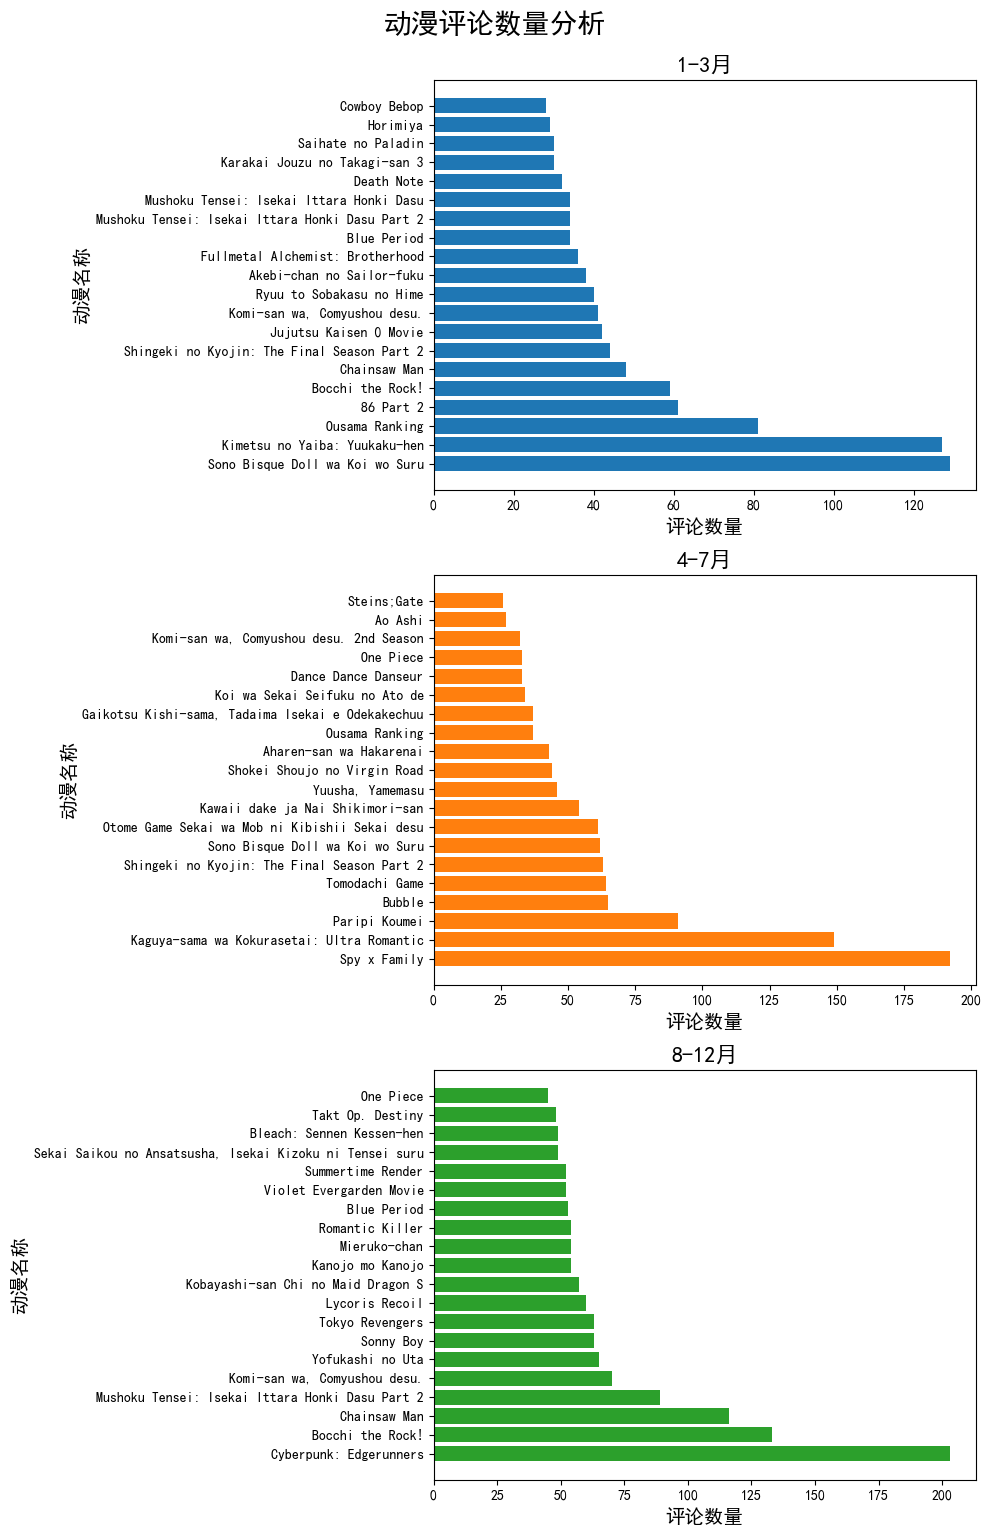

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 设置字体和解决负号显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']

plt.rcParams['axes.unicode_minus'] = False

# 读取每个季度的数据集
first_season_df = pd.read_csv("firstSeasonWordcount.csv")
second_season_df = pd.read_csv("secondSeasonWordcount.csv")
third_season_df = pd.read_csv("thirdSeasonWordcount.csv")

# 提取标题和评论数量，并按评论数量降序排序
first_season_sorted = first_season_df.sort_values(by="count", ascending=False).head(20)
first_season_titles = first_season_sorted["title"]
first_season_counts = first_season_sorted["count"]

second_season_sorted = second_season_df.sort_values(by="count", ascending=False).head(20)
second_season_titles = second_season_sorted["title"]
second_season_counts = second_season_sorted["count"]

third_season_sorted = third_season_df.sort_values(by="count", ascending=False).head(20)
third_season_titles = third_season_sorted["title"]
third_season_counts = third_season_sorted["count"]

# 创建子图
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# 颜色
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# 绘制第一个季度的条形图
axs[0].barh(first_season_titles, first_season_counts, color=colors[0])
axs[0].set_title("1-3月", fontsize=16)
axs[0].set_xlabel("评论数量", fontsize=14)
axs[0].set_ylabel("动漫名称", fontsize=14)

# 绘制第二个季度的条形图
axs[1].barh(second_season_titles, second_season_counts, color=colors[1])
axs[1].set_title("4-7月", fontsize=16)
axs[1].set_xlabel("评论数量", fontsize=14)
axs[1].set_ylabel("动漫名称", fontsize=14)

# 绘制第三个季度的条形图
axs[2].barh(third_season_titles, third_season_counts, color=colors[2])
axs[2].set_title("8-12月", fontsize=16)
axs[2].set_xlabel("评论数量", fontsize=14)
axs[2].set_ylabel("动漫名称", fontsize=14)

# 调整子图之间的间距
plt.tight_layout()

# 添加整体标题
plt.suptitle('动漫评论数量分析', fontsize=20, y=1.02)

# 显示图表
plt.show()


##### （二）从三个CSV文件中读取评论数据，并计算每个月的评论数量。然后，它使用matplotlib库创建一个柱状图来可视化这些数据，并在柱状图上添加折线图来展示
python代码如下所示

C:\Users\20624\AppData\Local\Temp\ipykernel_7396\3585905820.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  return pd.read_csv(file_name, error_bad_lines=False)
Skipping line 141: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 299: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 344: expected 5 fields, saw 6
Skipping line 350: expected 5 fields, saw 7
Skipping line 368: expected 5 fields, saw 8
Skipping line 449: expected 5 fields, saw 6
Skipping line 566: expected 5 fields, saw 6
Skipping line 763: expected 5 fields, saw 6
Skipping line 855: expected 5 fields, saw 6
Skipping line 856: expected 5 fields, saw 6
Skipping line 891: expected 5 fields, saw 6
Skipping line 913: expected 5 fields, saw 6
Skipping line 939: expected 5 fields, saw 7
Skipping line 1068: expected 5 fiel

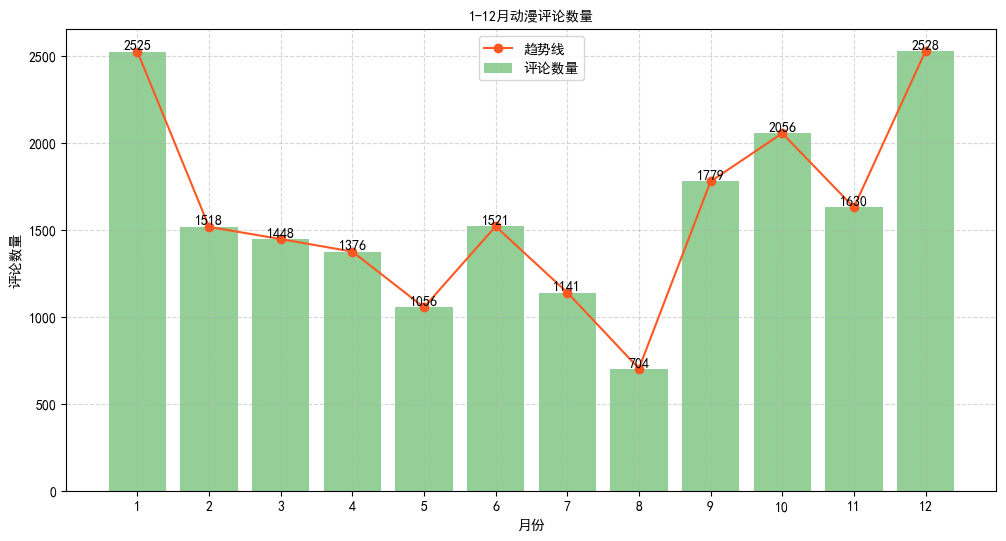

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 定义一个函数来读取CSV文件
# 参数：file_name - 要读取的CSV文件的名称
# 返回：一个DataFrame，包含CSV文件的内容
def read_csv(file_name):
    # error_bad_lines=False，这个参数意味着在读取时忽略错误行
    return pd.read_csv(file_name, error_bad_lines=False)

# 定义主函数
def main():
    # 评论文件列表
    comment_files = ['firstSeason.csv', 'secondSeason.csv', 'thirdSeason.csv']
    
    # 初始化一个列表，包含12个元素，每个元素都是0
    # 用于存储每个月的评论数量
    monthly_comments = [0] * 12
    
    # 遍历每个评论文件，计算每个月的评论数量
    for comment_file in comment_files:
        # 读取评论数据
        data = read_csv(comment_file)
        # 遍历数据的每一行
        for index, row in data.iterrows():
            # 将日期字符串转换为datetime对象
            comment_date = datetime.strptime(row['Date'], '%Y-%m-%d')
            # 获取月份
            month = comment_date.month
            # 累加每个月的评论数量
            monthly_comments[month - 1] += 1
    
    # 创建一个新的图表，并设置大小
    plt.figure(figsize=(12, 6))
    # 月份范围 (1-12)
    months = range(1, 13)
    # 创建柱状图表示每个月的评论数量
    bars = plt.bar(months, monthly_comments, color='#4CAF50', alpha=0.6, label='评论数量')
    
    # 创建折线图表示评论数量的趋势
    plt.plot(months, monthly_comments, color='#FF5722', marker='o', label='趋势线')
    
    # 为每个柱子添加评论数量标签
    for bar, comment_count in zip(bars, monthly_comments):
        height = bar.get_height()
        # 在每个柱子上方添加评论数量
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(comment_count),
                 ha='center', va='bottom')
    
    # 添加x轴和y轴的标签以及图表的标题
    plt.xlabel('月份')
    plt.ylabel('评论数量')
    plt.title('1-12月动漫评论数量', fontproperties='SimHei')
    plt.xticks(months)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # 显示图表
    plt.show()

# 当脚本作为主程序运行时，执行主函数
if __name__ == "__main__":
    main()


##### （三）每个月最受欢应的动漫及其评论数量

分析和可视化每个月评论最多的动漫及其评论数量。代码首先读取三个CSV文件中的评论数据，然后计算每个月每个动漫的评论数量并存储在一个嵌套的 defaultdict 中。接下来，代码遍历每个月并找出评论最多的动漫以及其评论数量。最后，使用matplotlib库创建一个水平条形图来可视化这些数据，并在每个条形旁边添加动漫名称和评论数量的标签。图表的y轴表示月份，x轴表示评论数量，并显示网格线。

C:\Users\20624\AppData\Local\Temp\ipykernel_7396\1459241275.py:11: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  return pd.read_csv(file_name, error_bad_lines=False)
Skipping line 141: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 299: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 344: expected 5 fields, saw 6
Skipping line 350: expected 5 fields, saw 7
Skipping line 368: expected 5 fields, saw 8
Skipping line 449: expected 5 fields, saw 6
Skipping line 566: expected 5 fields, saw 6
Skipping line 763: expected 5 fields, saw 6
Skipping line 855: expected 5 fields, saw 6
Skipping line 856: expected 5 fields, saw 6
Skipping line 891: expected 5 fields, saw 6
Skipping line 913: expected 5 fields, saw 6
Skipping line 939: expected 5 fields, saw 7
Skipping line 1068: expected 5 fiel

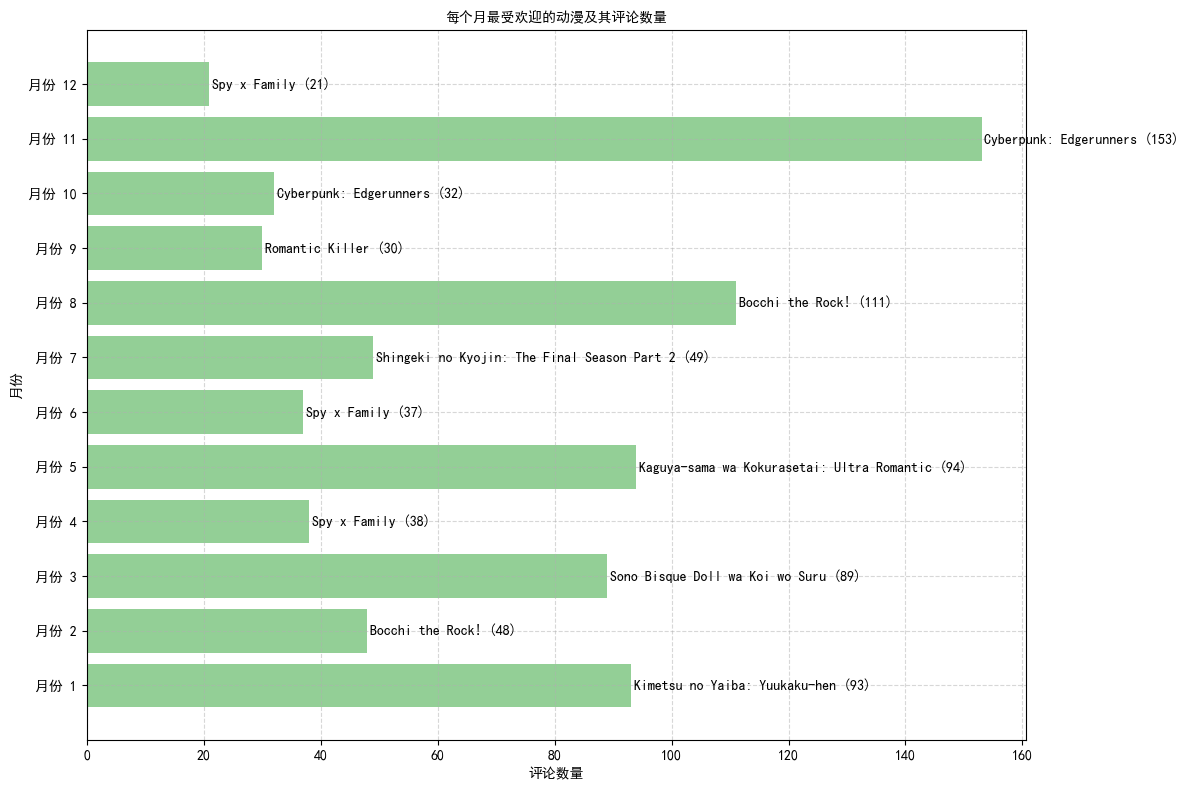

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# 定义一个函数来读取CSV文件
# 参数：file_name - 要读取的CSV文件的名称
# 返回：一个DataFrame，包含CSV文件的内容
def read_csv(file_name):
    # error_bad_lines=False，这个参数意味着在读取时忽略错误行
    return pd.read_csv(file_name, error_bad_lines=False)

# 定义主函数
def main():
    # 评论文件列表
    comment_files = ['firstSeason.csv', 'secondSeason.csv', 'thirdSeason.csv']
    
    # 初始化一个嵌套的 defaultdict，用于存储每个月每个动漫的评论数量
    # 默认值为int，即0
    monthly_anime_comments = defaultdict(lambda: defaultdict(int))
    
    # 遍历每个评论文件，计算每个月每个动漫的评论数量
    for comment_file in comment_files:
        # 读取评论数据
        data = read_csv(comment_file)
        # 遍历数据的每一行
        for index, row in data.iterrows():
            # 将日期字符串转换为datetime对象
            comment_date = datetime.strptime(row['Date'], '%Y-%m-%d')
            # 获取月份
            month = comment_date.month
            # 获取动漫标题
            anime_title = row['Title']
            # 累加每个动漫的评论数量
            monthly_anime_comments[month][anime_title] += 1
    
    # 找出每个月评论最多的动漫
    popular_animes = []
    max_comments = []
    # 遍历每个月
    for month, animes in monthly_anime_comments.items():
        # 找出该月评论最多的动漫
        popular_anime = max(animes, key=animes.get)
        # 将找到的动漫添加到列表中
        popular_animes.append(popular_anime)
        # 将最多评论数量添加到列表中
        max_comments.append(animes[popular_anime])

    # 创建一个水平条形图
    plt.figure(figsize=(12, 8))
    months = range(1, 13)
    # 绘制每个月评论最多的动漫的评论数量
    bars = plt.barh(months, max_comments, color='#4CAF50', alpha=0.6)
    
    # 添加动漫名称和评论数量标签
    for bar, popular_anime, comment_count in zip(bars, popular_animes, max_comments):
        width = bar.get_width()
        # 在每个条形旁边添加动漫名称和评论数量
        plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
                 f"{popular_anime} ({comment_count})", ha='left', va='center')
    
    # 添加y轴和x轴的标签以及图表的标题
    plt.ylabel('月份')
    plt.xlabel('评论数量')
    plt.title('每个月最受欢迎的动漫及其评论数量', fontproperties='SimHei')
    # 设置y轴的刻度标签
    plt.yticks(months, [f'月份 {month}' for month in months])
    # 显示网格
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # 显示图表
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


##### （四）每个季度评论占比

分析和可视化每个季度的动漫评论数量占比。首先，代码读取三个CSV文件中的评论数据，然后计算每个季度的评论数量并存储在一个列表中。然后，使用matplotlib库创建一个饼图来可视化这些数据。饼图显示了每个季度的评论数量占总评论

C:\Users\20624\AppData\Local\Temp\ipykernel_7396\1957454761.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  return pd.read_csv(file_name, error_bad_lines=False)
Skipping line 141: expected 5 fields, saw 6
Skipping line 202: expected 5 fields, saw 6
Skipping line 208: expected 5 fields, saw 6
Skipping line 299: expected 5 fields, saw 6
Skipping line 300: expected 5 fields, saw 6
Skipping line 344: expected 5 fields, saw 6
Skipping line 350: expected 5 fields, saw 7
Skipping line 368: expected 5 fields, saw 8
Skipping line 449: expected 5 fields, saw 6
Skipping line 566: expected 5 fields, saw 6
Skipping line 763: expected 5 fields, saw 6
Skipping line 855: expected 5 fields, saw 6
Skipping line 856: expected 5 fields, saw 6
Skipping line 891: expected 5 fields, saw 6
Skipping line 913: expected 5 fields, saw 6
Skipping line 939: expected 5 fields, saw 7
Skipping line 1068: expected 5 fiel

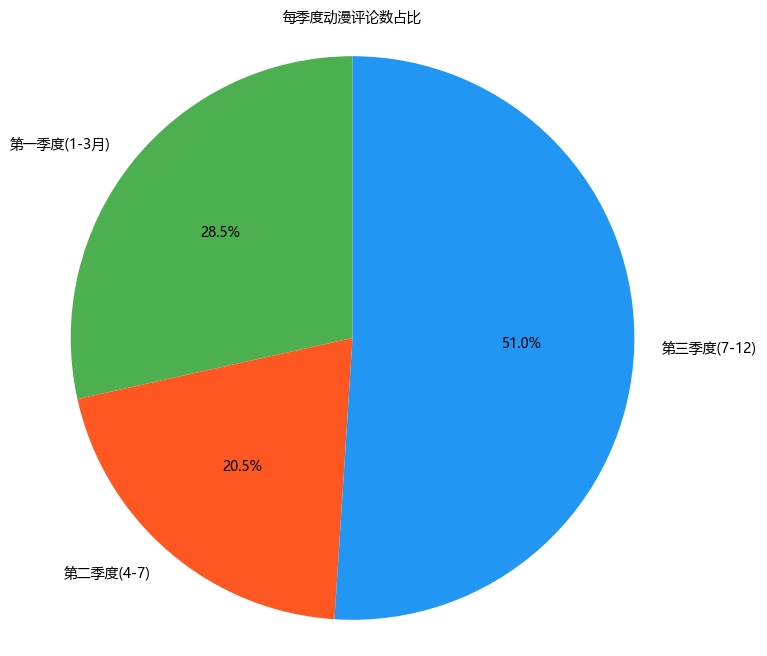

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 定义一个函数来读取CSV文件
# 参数：file_name - 要读取的CSV文件的名称
# 返回：一个DataFrame，包含CSV文件的内容
def read_csv(file_name):
    # error_bad_lines=False，这个参数意味着在读取时忽略错误行
    return pd.read_csv(file_name, error_bad_lines=False)

# 定义主函数
def main():
    # 评论文件列表
    comment_files = ['firstSeason.csv', 'secondSeason.csv', 'thirdSeason.csv']
    
    # 初始化季度评论数量列表
    quarterly_comments = [0, 0, 0]
    
    # 计算每个季度的评论数量
    for comment_file in comment_files:
        # 读取评论数据
        data = read_csv(comment_file)
        # 遍历数据的每一行
        for index, row in data.iterrows():
            # 将日期字符串转换为datetime对象
            date = pd.to_datetime(row['Date'])
            # 判断月份，根据月份增加对应季度的评论数量
            if date.month <= 3:
                quarterly_comments[0] += 1
            elif date.month <= 6:
                quarterly_comments[1] += 1
            else:
                quarterly_comments[2] += 1
    
    # 定义季度标签
    quarters = ['第一季度(1-3月)', '第二季度(4-7)', '第三季度(7-12)']
    
    # 导入中文字体，这是为了在图表中正确显示中文
    font = FontProperties(fname='C:\\Windows\\Fonts\\msyh.ttc')
    
    # 创建一个新的图表窗口
    plt.figure(figsize=(8, 8))
    # 绘制饼图，显示每个季度的评论数量占比
    plt.pie(quarterly_comments, labels=quarters, autopct='%1.1f%%',
            colors=['#4CAF50', '#FF5722', '#2196F3'], startangle=90, textprops={'fontproperties': font})
    # 添加图表标题
    plt.title('每季度动漫评论数占比', fontproperties=font)
    
    # 设置图表的坐标轴比例，使其保持相等，这样饼图将是一个完整的圆
    plt.axis('equal')
    # 显示图表
    plt.show()

# 当脚本作为主程序运行时，执行主函数
if __name__ == "__main__":
    main()


##### 2.3.2 再次将三个季度的csv文件上传至hdfs使用spark-shell编程将每个季度的数据集生成一个有动漫标题构成的动漫热词wordcout.csv文件
scala代码如下：
```
import org.apache.spark.sql.SparkSession

// 创建SparkSession对象
val spark = SparkSession.builder().appName("TitleWordCount").getOrCreate()

// 读取第一季度数据集并创建DataFrame
val firstSeasonDF = spark.read.option("header", true).csv("hdfs://hadoop01:9000/firstSeason.csv")

// 读取第二季度数据集并创建DataFrame
val secondSeasonDF = spark.read.option("header", true).csv("hdfs://hadoop01:9000/secondSeason.csv")

// 读取第三季度数据集并创建DataFrame
val thirdSeasonDF = spark.read.option("header", true).csv("hdfs://hadoop01:9000/thirdSeason.csv")

// 对第一季度数据集按照"Title"列进行分组并计数
val firstSeasonWordCount = firstSeasonDF.groupBy("Title").count()

// 对第二季度数据集按照"Title"列进行分组并计数
val secondSeasonWordCount = secondSeasonDF.groupBy("Title").count()

// 对第三季度数据集按照"Title"列进行分组并计数
val thirdSeasonWordCount = thirdSeasonDF.groupBy("Title").count()

// 将第一季度的词频统计结果写入CSV文件
firstSeasonWordCount.coalesce(1).write.csv("hdfs://hadoop01:9000/firstSeasonWordcount.csv")

// 将第二季度的词频统计结果写入CSV文件
secondSeasonWordCount.coalesce(1).write.csv("hdfs://hadoop01:9000/secondSeasonWordcount.csv")

// 将第三季度的词频统计结果写入CSV文件
thirdSeasonWordCount.coalesce(1).write.csv("hdfs://hadoop01:9000/thirdSeasonWordcount.csv")

// 停止SparkSession
spark.stop()

```
最后将生成的结果下载到本地分别命名为firstSeasonWordcount.csv,secondSeasonWordcount.csv,thirdSeasonWordcount.csv分别表示三个季度动漫标题的出现次数进行统计
firstSeasonWordcount.csv的部分数据如下：它的涵义比如动画Kengan Ashura Part2，1表示拳愿阿修罗第二季，在第一季度被不同用户评论了一次
```
title,count
Kengan Ashura Part 2,1
Seihou Bukyou Outlaw Star,1
"Komi-san wa, Comyushou desu. 2nd Season",2
Yuuki Yuuna wa Yuusha de Aru,1
One Piece Movie 01,1
K,1
Kaginado,1
Mushoku Tensei: Isekai Ittara Honki Dasu - Eris no Goblin Toubatsu,10
JoJo no Kimyou na Bouken Part 3: Stardust Crusaders 2nd Season,2
The Sky Crawlers,2
Bakuman.,1
Suzumiya Haruhi no Yuuutsu (2009),2
Fullmetal Alchemist,1
Nichijou,4
```
secondSeasonWordcount.csv的部分数据如下：
```
title,count
Steins;Gate 0: Kesshou Takei no Valentine - Bittersweet Intermedio,1
"Komi-san wa, Comyushou desu. 2nd Season",32
Kaginado,1
Shinryaku! Ika Musume Specials,1
Air Movie,2
Yuuki Yuuna wa Yuusha de Aru,1
Vatican Kiseki Chousakan,2
Fullmetal Alchemist,3
Love Kome: We Love Rice,1
Bakuman.,3
Shinka no Mi: Shiranai Uchi ni Kachigumi Jinsei,2
Nichijou,3
Mushoku Tensei: Isekai Ittara Honki Dasu - Eris no Goblin Toubatsu,2
```
thirdSeasonWordcount.csv
```
title,count
Seihou Bukyou Outlaw Star,2
"Komi-san wa, Comyushou desu. 2nd Season",3
Ai no Gakkou Cuore Monogatari,1
Kaginado,7
Yuuki Yuuna wa Yuusha de Aru,3
One Piece Movie 01,2
Momokuri,1
Kidou Senshi Gundam: The Origin - Zenya Akai Suisei,1
A Kite,2
JoJo no Kimyou na Bouken Part 3: Stardust Crusaders 2nd Season,5
Arknights: Reimei Zensou,10
Nichijou,6
The Sky Crawlers,2
Bakuman.,6
```

##### 2.3.3根据得到的结果使用python进行可视化

##### 三个季度的动漫标题热词

使用pandas、WordCloud和matplotlib.pyplot库读取CSV文件中的数据，并生成相应季度的热门动漫词云图。
读取每个季度的词频统计数据文件，将数据转换为字典格式，并生成相应季度的热门动漫词云图。每个季度的词云图将根据评论数量的不同，以不同字体大小和词语的频率来展示。通过词云图可以直观地显示出每个季度的热门动漫。

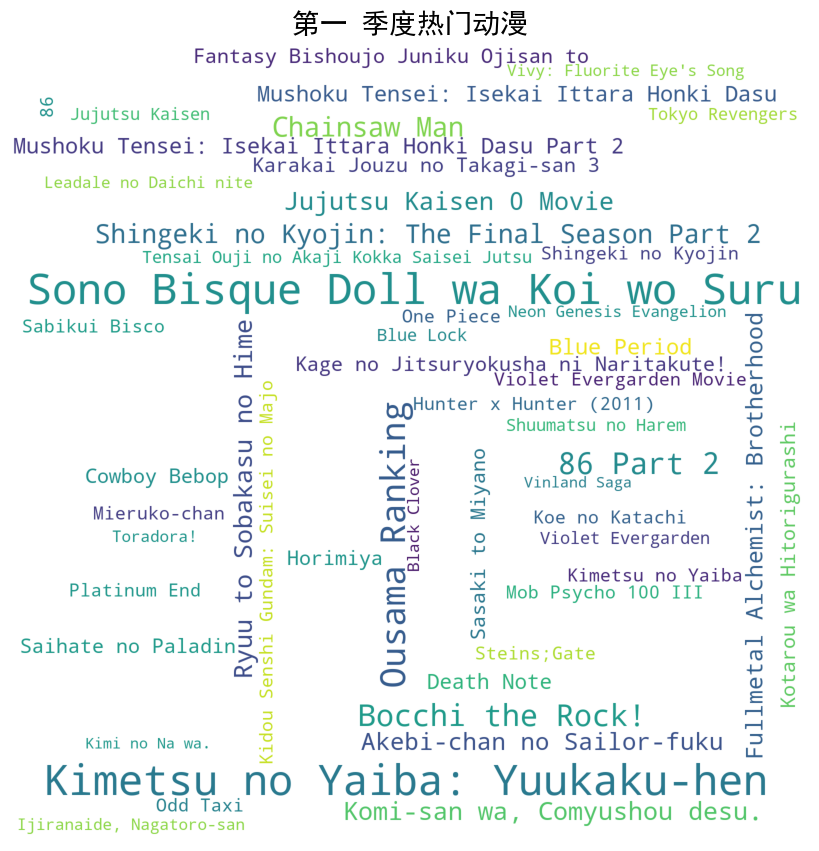

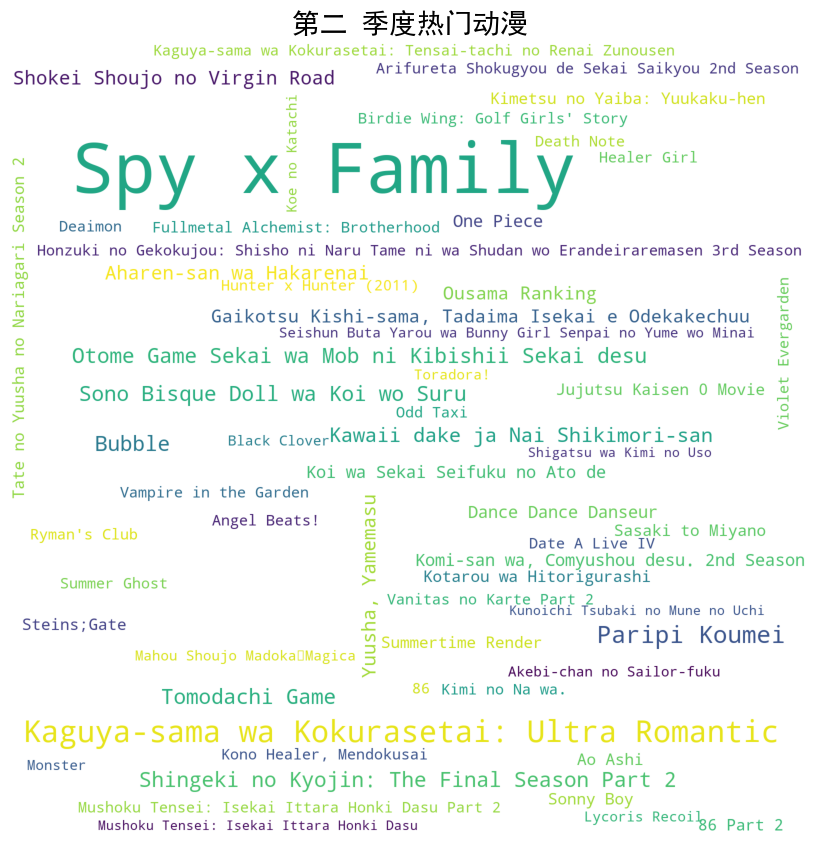

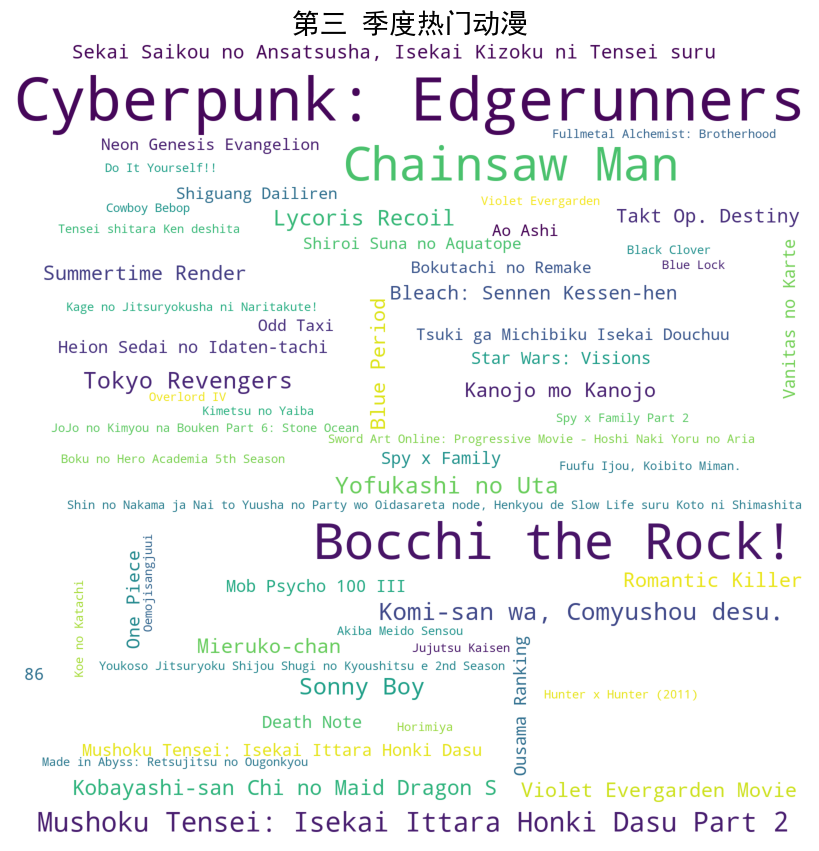

In [2]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 为matplotlib设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei'] # 使用黑体 ('SimHei') 作为中文字体
plt.rcParams['axes.unicode_minus'] = False # 解决负号'-'显示为方块的问题

# 读取CSV文件的函数
# 参数：file_name - CSV文件的名称
# 返回：读取到的DataFrame
def read_csv(file_name):
    return pd.read_csv(file_name)

# 生成词云图的函数
# 参数：
# data - 一个字典，包含了词及其对应的频率
# quarter - 表示季度的字符串
# max_words - 词云图中显示的最大单词数
# max_font_size - 词云图中最大字体大小
# min_font_size - 词云图中最小字体大小
# scale - 用于调整词云图的清晰度
def generate_wordcloud(data, quarter, max_words=60, max_font_size=None, min_font_size=10, scale=1):
    # 创建WordCloud对象并设置相关参数
    wordcloud = WordCloud(width=800,
                          height=800,
                          background_color='white',
                          max_words=max_words,
                          max_font_size=max_font_size,
                          min_font_size=min_font_size,
                          scale=scale).generate_from_frequencies(data)
    
    # 创建图表
    plt.figure(figsize=(8, 8), facecolor=None)
    # 绘制词云图
    plt.imshow(wordcloud)
    # 隐藏坐标轴
    plt.axis("off")
    # 调整布局
    plt.tight_layout(pad=0)
    # 设置标题
    plt.title(f'{quarter} 季度热门动漫', fontsize=20)
    # 显示图表
    plt.show()

# 主函数
def main():
    # 季度和对应的文件名
    quarters = ['第一', '第二', '第三']
    file_names = ['firstSeasonWordcount.csv', 'secondSeasonWordcount.csv', 'thirdSeasonWordcount.csv']
    
    # 对每个季度生成词云图
    for quarter, file_name in zip(quarters, file_names):
        # 读取CSV文件并获取数据
        data = read_csv(file_name)
        # 将数据转换为字典格式 {title: count}
        data_dict = dict(zip(data['title'], data['count']))
        # 生成词云图
        generate_wordcloud(data_dict, quarter, max_font_size=70, scale=2)

# 执行主函数
if __name__ == "__main__":
    main()
